In [1]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
print(""" Finetuning the library models for sequence classification on GLUE (Bert, XLM, XLNet, RoBERTa).""")
print(""" Modification of the original script for News-Frame detection""")

 Finetuning the library models for sequence classification on GLUE (Bert, XLM, XLNet, RoBERTa).
 Modification of the original script for News-Frame detection


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [3]:
# del os.environ['CUDA_VISIBLE_DEVICES']

In [1]:
from __future__ import absolute_import, division, print_function

import argparse
import glob
import logging
import os
import random
import sys
import pandas as pd
from scipy.special import expit, softmax
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F

from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tensorboardX import SummaryWriter
from tqdm import tqdm, trange

In [2]:
from transformers import (WEIGHTS_NAME, BertPreTrainedModel, BertConfig, BertModel,
                                  BertForSequenceClassification, BertTokenizer,
                                  RobertaConfig,
                                  RobertaForSequenceClassification,
                                  RobertaTokenizer,
                                  XLMConfig, XLMForSequenceClassification,
                                  XLMTokenizer, XLNetConfig,
                                  XLNetForSequenceClassification,
                                  XLNetTokenizer,
                                  DistilBertConfig,
                                  DistilBertForSequenceClassification,
                                  DistilBertTokenizer)

from transformers import AdamW, WarmupLinearSchedule
from transformers import DataProcessor
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_output_modes as output_modes
output_modes["frame"] = "classification"
from transformers import glue_processors as processors
# from transformers import glue_convert_examples_to_features as convert_examples_to_features

I1113 12:44:30.031979 47186697148864 file_utils.py:39] PyTorch version 1.1.0 available.
I1113 12:44:30.931105 47186697148864 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [3]:
# np.set_printoptions(threshold=sys.maxsize)

In [4]:
logger = logging.getLogger(__name__)

ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (BertConfig, XLNetConfig, XLMConfig, 
                                                                                RobertaConfig, DistilBertConfig)), ())


In [7]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()
        self.inverse_normed_freqs = None
        
    def set_inverse_normed_freqs(self, args, inverse_normed_freqs):
        self.inverse_normed_freqs = inverse_normed_freqs.to(args.device)
#         print("Inverse Normed Freqs after set: ", self.inverse_normed_freqs)
        

    def forward(self, input_ids, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, labels=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids, 
                            head_mask=head_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
#             loss_fct = BCEWithLogitsLoss()
#             print("inverse freqs before sending to loss", self.inverse_normed_freqs)
            loss = FocalLoss(logits, labels, self.inverse_normed_freqs) 
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels).float())
            outputs = (loss,) + outputs
        return outputs  # (loss), logits, (hidden_states), (attentions)

        
#     def freeze_bert_encoder(self):
#         for param in self.bert.parameters():
#             param.requires_grad = False
    
#     def unfreeze_bert_encoder(self):
#         for param in self.bert.parameters():
#             param.requires_grad = True


MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'bertmultilabel': (BertConfig, BertForMultiLabelSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer)
}

In [8]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.
    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    def __init__(self, guid, text_a, text_b=None, labels=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"


class InputFeatures(object):
    """
    A single set of features of data.
    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
            Mask values selected in ``[0, 1]``:
            Usually  ``1`` for tokens that are NOT MASKED, ``0`` for MASKED (padded) tokens.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        label: Label corresponding to the input
    """

    def __init__(self, input_ids, attention_mask, token_type_ids, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.labels = labels

In [9]:
class MultiLabelTextProcessor(DataProcessor):

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["1","2","3","4","5","6","7","8","9"]
    
    def get_inverse_normed_freqs(self, data_dir):
        lines = self._read_tsv(os.path.join(data_dir, "train.tsv"))
        freqs = [0] * 9
        for line in lines:
            labels = line[3:]
#             print("line:", line)
#             print("labels:", labels)
            for (i,label) in enumerate(labels):
#                 print((i,label))
                if float(label):
#                     print(label)
                    freqs[i] = freqs[i]+1
        inverse_freqs = [1./f for f in freqs]
#         print("freqs", freqs)
#         print("inverse freqs", inverse_freqs)
        total_inverse_freqs = sum(inverse_freqs)
        inverse_normed_freqs = [i/total_inverse_freqs for i in inverse_freqs]
        return torch.FloatTensor(inverse_normed_freqs)
    


    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            labels = line[3:]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, labels=labels))
        return examples

processors["frame"] = MultiLabelTextProcessor

In [10]:
def convert_examples_to_features(examples, tokenizer,
                                      max_length=512,
                                      task=None,
                                      label_list=None,
                                      output_mode=None,
                                      pad_on_left=False,
                                      pad_token=0,
                                      pad_token_segment_id=0,
                                      mask_padding_with_zero=True):
    """
    Loads a data file into a list of ``InputFeatures``
    Args:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum example length
        task: GLUE task
        label_list: List of labels. Can be obtained from the processor using the ``processor.get_labels()`` method
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0, but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1`` for actual values
            and by ``0`` for padded values. If set to ``False``, inverts it (``1`` for padded values, ``0`` for
            actual values)
    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.
    """
#     is_tf_dataset = False
#     if is_tf_available() and isinstance(examples, tf.data.Dataset):
#         is_tf_dataset = True

#     if task is not None:
#         processor = glue_processors[task]()
#         if label_list is None:
#             label_list = processor.get_labels()
#             logger.info("Using label list %s for task %s" % (label_list, task))
#         if output_mode is None:
#             output_mode = glue_output_modes[task]
#             logger.info("Using output mode %s for task %s" % (output_mode, task))

#     label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d" % (ex_index))
#         if is_tf_dataset:
#             example = processor.get_example_from_tensor_dict(example)

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)

#         if output_mode == "classification":
#             label = label_map[example.label]
#         elif output_mode == "regression":
#             label = f`loat(example.label)
#         else:
#             raise KeyError(output_mode)

#         labels_ids = []
#         for label in example.labels:
#             labels_ids.append(float(label))
            
        labels = [float(i) for i in example.labels]

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            logger.info("label: %s" % (example.labels))

        features.append(
                InputFeatures(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              labels=labels))

#     if is_tf_available() and is_tf_dataset:
#         def gen():
#             for ex in features:
#                 yield  ({'input_ids': ex.input_ids,
#                          'attention_mask': ex.attention_mask,
#                          'token_type_ids': ex.token_type_ids},
#                         ex.label)

#         return tf.data.Dataset.from_generator(gen,
#             ({'input_ids': tf.int32,
#               'attention_mask': tf.int32,
#               'token_type_ids': tf.int32},
#              tf.int64),
#             ({'input_ids': tf.TensorShape([None]),
#               'attention_mask': tf.TensorShape([None]),
#               'token_type_ids': tf.TensorShape([None])},
#              tf.TensorShape([])))

    return features

In [11]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [12]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        tb_writer = SummaryWriter()

    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    if args.max_steps > 0:
        t_total = args.max_steps
        args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
    else:
        t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)
    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank],
                                                          output_device=args.local_rank,
                                                          find_unused_parameters=True)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                   args.train_batch_size * args.gradient_accumulation_steps * (torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0])
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    # Log metrics
                    if args.local_rank == -1 and args.evaluate_during_training:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args.logging_steps, global_step)
                    logging_loss = tr_loss

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args.output_dir, 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    torch.save(args, os.path.join(output_dir, 'training_args.bin'))
                    logger.info("Saving model checkpoint to %s", output_dir)

            if args.max_steps > 0 and global_step > args.max_steps:
                epoch_iterator.close()
                break
        if args.max_steps > 0 and global_step > args.max_steps:
            train_iterator.close()
            break

    if args.local_rank in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

In [13]:
def plot_roc(fpr, tpr, roc_auc, output_dir=False):
    plt.figure()
    lw = 2
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], #color='darkorange',
                 lw=lw, label='Frame %d (area = %0.2f)' % (int(i+1), roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    if output_dir:
        plt.savefig(os.path.join(output_dir, "auc.png"))
    plt.show()

In [14]:
def evaluate(args, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = ("mnli", "mnli-mm") if args.task_name == "mnli" else (args.task_name,)
    eval_outputs_dirs = (args.output_dir, args.output_dir + '-MM') if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = load_and_cache_examples(args, eval_task, tokenizer, evaluate=True)

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

        # Eval!
        logger.info("***** Running evaluation {} *****".format(prefix))
        logger.info("  Num examples = %d", len(eval_dataset))
        logger.info("  Batch size = %d", args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         batch[3]}
                if args.model_type != 'distilbert':
                    inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs['labels'].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
#         if args.output_mode == "classification":
#             preds = np.argmax(preds, axis=1)
#         elif args.output_mode == "regression":
#             preds = np.squeeze(preds)
        
#         preds = softmax(preds, axis=1)
        preds = expit(preds)
        print("preds shape: ", preds.shape)
        print("out label ids: ", out_label_ids.shape)
        print(preds[:5])
        print(out_label_ids[:5])

        return preds
#         output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
#         with open(output_eval_file, "w") as writer:
#             logger.info("***** Eval results {} *****".format(prefix))
#             for key in sorted(results.keys()):
#                 logger.info("  %s = %s", key, str(results[key]))
#                 writer.write("%s = %s\n" % (key, str(results[key])))

#     return results

In [15]:
def load_and_cache_examples(args, task, tokenizer, evaluate=False):
    if args.local_rank not in [-1, 0] and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    processor = processors[task]()
    output_mode = output_modes[task]
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(args.data_dir, 'cached_{}_{}_{}_{}'.format(
        'dev' if evaluate else 'train',
        list(filter(None, args.model_name_or_path.split('/'))).pop(),
        str(args.max_seq_length),
        str(task)))
    if os.path.exists(cached_features_file):
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        label_list = processor.get_labels()
        if task in ['mnli', 'mnli-mm'] and args.model_type in ['roberta']:
            # HACK(label indices are swapped in RoBERTa pretrained model)
            label_list[1], label_list[2] = label_list[2], label_list[1] 
        examples = processor.get_dev_examples(args.data_dir) if evaluate else processor.get_train_examples(args.data_dir)
        features = convert_examples_to_features(examples,
                                                tokenizer,
                                                label_list=label_list,
                                                max_length=args.max_seq_length,
                                                output_mode=output_mode,
                                                pad_on_left=bool(args.model_type in ['xlnet']),                 # pad on the left for xlnet
                                                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                pad_token_segment_id=4 if args.model_type in ['xlnet'] else 0,
        )
#         if args.local_rank in [-1, 0]:
#             logger.info("Saving features into cached file %s", cached_features_file)
#             torch.save(features, cached_features_file)

    if args.local_rank == 0 and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_labels = torch.tensor([f.labels for f in features], dtype=torch.long) #list of list happens ?
    elif output_mode == "regression":
        all_labels = torch.tensor([f.labels for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

In [16]:
def main():
    parser = argparse.ArgumentParser()

    ## Required parameters
    parser.add_argument("--data_dir", default=None, type=str, required=True,
                        help="The input data dir. Should contain the .tsv files (or other data files) for the task.")
    parser.add_argument("--model_type", default=None, type=str, required=True,
                        help="Model type selected in the list: " + ", ".join(MODEL_CLASSES.keys()))
    parser.add_argument("--model_name_or_path", default=None, type=str, required=True,
                        help="Path to pre-trained model or shortcut name selected in the list: " + ", ".join(ALL_MODELS))
    parser.add_argument("--task_name", default=None, type=str, required=True,
                        help="The name of the task to train selected in the list: " + ", ".join(processors.keys()))
    parser.add_argument("--output_dir", default=None, type=str, required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")

    ## Other parameters
    parser.add_argument("--config_name", default="", type=str,
                        help="Pretrained config name or path if not the same as model_name")
    parser.add_argument("--tokenizer_name", default="", type=str,
                        help="Pretrained tokenizer name or path if not the same as model_name")
    parser.add_argument("--cache_dir", default="", type=str,
                        help="Where do you want to store the pre-trained models downloaded from s3")
    parser.add_argument("--max_seq_length", default=128, type=int,
                        help="The maximum total input sequence length after tokenization. Sequences longer "
                             "than this will be truncated, sequences shorter will be padded.")
    parser.add_argument("--do_train", action='store_true',
                        help="Whether to run training.")
    parser.add_argument("--do_eval", action='store_true',
                        help="Whether to run eval on the dev set.")
    parser.add_argument("--evaluate_during_training", action='store_true',
                        help="Rul evaluation during training at each logging step.")
    parser.add_argument("--do_lower_case", action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--german", action='store_true',
                        help="Set this flag if you are evaluating in german.")

    parser.add_argument("--per_gpu_train_batch_size", default=8, type=int,
                        help="Batch size per GPU/CPU for training.")
    parser.add_argument("--per_gpu_eval_batch_size", default=8, type=int,
                        help="Batch size per GPU/CPU for evaluation.")
    parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                        help="Number of updates steps to accumulate before performing a backward/update pass.")
    parser.add_argument("--learning_rate", default=5e-5, type=float,
                        help="The initial learning rate for Adam.")
    parser.add_argument("--weight_decay", default=0.0, type=float,
                        help="Weight deay if we apply some.")
    parser.add_argument("--adam_epsilon", default=1e-8, type=float,
                        help="Epsilon for Adam optimizer.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float,
                        help="Max gradient norm.")
    parser.add_argument("--num_train_epochs", default=3.0, type=float,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--max_steps", default=-1, type=int,
                        help="If > 0: set total number of training steps to perform. Override num_train_epochs.")
    parser.add_argument("--warmup_steps", default=0, type=int,
                        help="Linear warmup over warmup_steps.")

    parser.add_argument('--logging_steps', type=int, default=50,
                        help="Log every X updates steps.")
    parser.add_argument('--save_steps', type=int, default=500,
                        help="Save checkpoint every X updates steps.")
    parser.add_argument("--eval_all_checkpoints", action='store_true',
                        help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number")
    parser.add_argument("--no_cuda", action='store_true',
                        help="Avoid using CUDA when available")
    parser.add_argument('--overwrite_output_dir', action='store_true',
                        help="Overwrite the content of the output directory")
    parser.add_argument('--overwrite_cache', action='store_true',
                        help="Overwrite the cached training and evaluation sets")
    parser.add_argument('--seed', type=int, default=42,
                        help="random seed for initialization")

    parser.add_argument('--fp16', action='store_true',
                        help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit")
    parser.add_argument('--fp16_opt_level', type=str, default='O1',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")
    parser.add_argument("--local_rank", type=int, default=-1,
                        help="For distributed training: local_rank")
    parser.add_argument('--server_ip', type=str, default='', help="For distant debugging.")
    parser.add_argument('--server_port', type=str, default='', help="For distant debugging.")
    
    args = parser.parse_args(ARGS)
#     print("ARGS MODEL NAME OR PATH", args.model_name_or_path)
#     print("CACHE DIR", args.cache_dir)

    if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.do_train and not args.overwrite_output_dir:
        raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args.output_dir))

    # Setup distant debugging if needed
    if args.server_ip and args.server_port:
        # Distant debugging - see https://code.visualstudio.com/docs/python/debugging#_attach-to-a-local-script
        import ptvsd
        print("Waiting for debugger attach")
        ptvsd.enable_attach(address=(args.server_ip, args.server_port), redirect_output=True)
        ptvsd.wait_for_attach()

    # Setup CUDA, GPU & distributed training
    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        args.n_gpu = torch.cuda.device_count()
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        torch.distributed.init_process_group(backend='nccl')
        args.n_gpu = 1
    args.device = device

    # Setup logging
    logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt = '%m/%d/%Y %H:%M:%S',
                        level = logging.INFO if args.local_rank in [-1, 0] else logging.WARN)
    logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
                    args.local_rank, device, args.n_gpu, bool(args.local_rank != -1), args.fp16)

    # Set seed
    set_seed(args)

    # Prepare GLUE task
    args.task_name = args.task_name.lower()
    if args.task_name not in processors:
        raise ValueError("Task not found: %s" % (args.task_name))
    processor = processors[args.task_name]()
    args.output_mode = output_modes[args.task_name]
    label_list = processor.get_labels()
    num_labels = len(label_list)

    # Load pretrained model and tokenizer
    if args.local_rank not in [-1, 0]:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

    args.model_type = args.model_type.lower()
    config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
    config = config_class.from_pretrained(args.config_name if args.config_name else 
                                          args.model_name_or_path, num_labels=num_labels, finetuning_task=args.task_name)
    tokenizer = tokenizer_class.from_pretrained(args.tokenizer_name if args.tokenizer_name else 
                                                args.model_name_or_path, do_lower_case=args.do_lower_case)
    model = model_class.from_pretrained(args.model_name_or_path, 
                                        from_tf=bool('.ckpt' in args.model_name_or_path),
                                        config=config)

    if args.local_rank == 0:
        torch.distributed.barrier()  # Make sure only the first process in distributed training will download model & vocab

#     print("args.device", args.device)
    

    logger.info("Training/evaluation parameters %s", args)
    
    if args.german:
        model.set_inverse_normed_freqs(args,torch.ones(num_labels)) 
    else:
        model.set_inverse_normed_freqs(args,processor.get_inverse_normed_freqs(args.data_dir)) 
    
    model.to(args.device)
    # Training
    if args.do_train:
        # this would crash with other tasks
        
        train_dataset = load_and_cache_examples(args, args.task_name, tokenizer, evaluate=False)
        global_step, tr_loss = train(args, train_dataset, model, tokenizer) #here
        logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)


    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    if args.do_train and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
        # Create output directory if needed
        if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(args.output_dir)

        logger.info("Saving model checkpoint to %s", args.output_dir)
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)

        # Good practice: save your training arguments together with the trained model
        torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))

        # Load a trained model and vocabulary that you have fine-tuned
        model = model_class.from_pretrained(args.output_dir)
        tokenizer = tokenizer_class.from_pretrained(args.output_dir, 
                                                    do_lower_case=args.do_lower_case)
        model.to(args.device)


    # Evaluation
    results = {}
    if args.do_eval and args.local_rank in [-1, 0]:
        tokenizer = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
        checkpoints = [args.output_dir]
        if args.eval_all_checkpoints:
            checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args.output_dir + '/**/' + WEIGHTS_NAME, recursive=True)))
            logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
        logger.info("Evaluate the following checkpoints: %s", checkpoints)
        for checkpoint in checkpoints:
            global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
            model = model_class.from_pretrained(checkpoint)
            if args.german:
                model.set_inverse_normed_freqs(args,torch.ones(num_labels)) 
            else:
                model.set_inverse_normed_freqs(args,processor.get_inverse_normed_freqs(args.data_dir)) 
            model.to(args.device)
            result = evaluate(args, model, tokenizer, prefix=global_step)
            return(result)
#             result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
#             results.update(result)

#     return results

# if __name__ == "__main__":
#     main()

In [17]:
def FocalLoss(logits, labels, inverse_normed_freqs):
    labels = labels.type(torch.float32)
    probs = torch.sigmoid(logits)

#     print("probs: ", probs)
#     print("labels: ", labels)
    pt = (1 - labels) * (1 - probs) + labels * probs
    log_pt = torch.log(pt)
#     print("pt: ", pt)
#     print("log_pt: ", log_pt)
    floss = - (1 - pt)**2 * log_pt
#     print("floss: ", floss)
#     print("inverse_normed_freqs in focal loss: ",inverse_normed_freqs)
    floss_weighted =  floss * inverse_normed_freqs #torch.autograd.Variable(floss * inverse_normed_freqs)
#     floss_weighted = floss
    #     q = 1 - probs
#     fl = torch.autograd.Variable(q * q * log_probs) #torch.mul(torch.mul(q,q), log_probs)
#     print(fl.type())
#     print(inverse_normed_freqs.type())
#     fl_weighted = torch.autograd.Variable(fl * inverse_normed_freqs)#torch.mul(fl, inverse_normed_freqs)
#     print("floss_weighted ", floss_weighted)
    return torch.mean(floss_weighted)
#     loss_fct = BCEWithLogitsLoss(pos_weight=inverse_normed_freqs)
#     loss = loss_fct(fl.view(-1, self.num_labels), labels.view(-1, self.num_labels).float())
#     return loss

In [16]:
def SoftmaxFocalLoss(logits, labels, inverse_normed_freqs):
    labels = labels.type(torch.float32)
    m = nn.Softmax(dim=1)
    probs = m(logits)
    logprobs = torch.log(probs) * inverse_normed_freqs
    logyhat_for_gold = labels * logprobs
#     print(logyhat_for_gold)
    logyhat_for_gold_summed = torch.sum(logyhat_for_gold, dim=1)
#     print(logyhat_for_gold_summed)
    return torch.mean(-logyhat_for_gold_summed)

In [33]:
def SoftmaxLoss(logits, labels, inverse_normed_freqs):
    labels = labels.type(torch.float32)
    m = nn.Softmax(dim=1)
    probs = m(logits)
    logyhat_for_gold = labels * torch.log(probs)
#     print(logyhat_for_gold)
    logyhat_for_gold_summed = torch.sum(logyhat_for_gold, dim=1)
#     print(logyhat_for_gold_summed)
    return torch.mean(-logyhat_for_gold_summed)

In [18]:
def NormalizedLogSoftmaxLoss(logits, labels, inverse_normed_freqs):
    labels = labels.type(torch.float32)
    m = nn.Softmax(dim=1)
    probs = m(logits)
    logyhat_for_gold = labels * torch.log(probs)
#     print(logyhat_for_gold)
    logyhat_for_gold_normalized_summed = torch.sum(logyhat_for_gold / labels.sum(dim=1).reshape((-1,1)), dim=1)
#     print(logyhat_for_gold_normalized_summed)
    return torch.mean(-logyhat_for_gold_normalized_summed)


In [19]:
def LogNormalizedSoftmaxLoss(logits, labels, inverse_normed_freqs):
    labels = labels.type(torch.float32)
    m = nn.Softmax(dim=1)
    probs = m(logits)
#     print(labels)
#     print(probs)
    yhat_for_gold = labels * probs
#     print(yhat_for_gold)
    yhat_for_gold_normalized = torch.sum(yhat_for_gold / labels.sum(dim=1).reshape((-1,1)),dim=1)
#     print(yhat_for_gold_normalized)
    logyhat_for_gold_normalized = torch.log(yhat_for_gold_normalized)
#     print(logyhat_for_gold_normalized)
    return torch.mean(-logyhat_for_gold_normalized)

In [18]:
ARGS = ["--model_type", 'bertmultilabel',
    "--data_dir", 'dataset/',
    "--task_name", 'frame',
    "--model_name_or_path", 'bert_base_uncased',
    "--output_dir", 'bert_output_multilingual_cased_30shot',
    "--cache_dir", '/projectnb/llamagrp/feyzanb/.cache/newsframing/',
    "--max_seq_length", "128",
#     "--do_train", 
    "--do_eval",
    "--do_lower_case",
    "--per_gpu_train_batch_size", "4",
    "--learning_rate", "2e-5",
    "--num_train_epochs", "10.0"#,
#     "--overwrite_output_dir",
#     "--overwrite_cache"#,
#     "--german"
       ]

In [19]:
results_folds = {} 

In [20]:
for i in range(5):
    # train and test for fold i
    ARGS[7] = "bert-base-uncased"
    ARGS[3] = "dataset/"+str(i)
    # output for fold i
    ARGS[9] = "/projectnb/llamagrp/feyzanb/bert_output_uncased/" + str(i)
    # cache folder for fold i
    ARGS[11] = "/projectnb/llamagrp/feyzanb/.cache/newsframing/english/" + str(i)
    print(ARGS)
    results_folds[i] = main()
#     print(results_folds[i])

W1113 12:47:43.130322 47186697148864 <ipython-input-16-f7769f312fc9>:114] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False


['--model_type', 'bertmultilabel', '--data_dir', 'dataset/0', '--task_name', 'frame', '--model_name_or_path', 'bert-base-uncased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_uncased/0', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/english/0', '--max_seq_length', '128', '--do_eval', '--do_lower_case', '--per_gpu_train_batch_size', '4', '--learning_rate', '2e-5', '--num_train_epochs', '10.0']


I1113 12:47:43.311354 47186697148864 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1113 12:47:43.313266 47186697148864 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1113 12:47:43.427211 471866971488

I1113 12:47:55.817383 47186697148864 <ipython-input-10-f72b0bac0eba>:98] label: ['0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0']
I1113 12:47:55.819840 47186697148864 <ipython-input-10-f72b0bac0eba>:93] *** Example ***
I1113 12:47:55.820634 47186697148864 <ipython-input-10-f72b0bac0eba>:94] guid: dev-2
I1113 12:47:55.821457 47186697148864 <ipython-input-10-f72b0bac0eba>:95] input_ids: 101 15419 14774 6473 3658 2055 4815 1037 3282 2044 2346 7385 5043 1010 17016 2000 2681 1520 9458 3566 1016 1521 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1113 12:47:55.822313 47186697148864 <ipython-input-10-f72b0bac0eba>:96] attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

preds shape:  (263, 9)
out label ids:  (263, 9)
[[0.04340864 0.12741871 0.36479062 0.73051023 0.29104042 0.08762373
  0.07951498 0.03697357 0.05642395]
 [0.04692642 0.11594824 0.21871622 0.07402629 0.3543731  0.8389425
  0.12013794 0.09937272 0.08372583]
 [0.05557809 0.15619554 0.31571555 0.445836   0.0868151  0.07386196
  0.2564693  0.04908425 0.0436422 ]
 [0.05897277 0.19968487 0.2119074  0.78304243 0.24766329 0.11617464
  0.09429694 0.08327261 0.05109496]
 [0.0755087  0.13720283 0.18288729 0.0828888  0.13408856 0.8981723
  0.18593797 0.0495123  0.08220718]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
['--model_type', 'bertmultilabel', '--data_dir', 'dataset/1', '--task_name', 'frame', '--model_name_or_path', 'bert-base-uncased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_uncased/1', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/english/1', '--max_seq_length', '128', '--do_eval', '--do_lower_

I1113 12:47:57.990742 47186697148864 modeling_utils.py:337] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache at /usr4/cs591/akyurek/.cache/torch/transformers/aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
I1113 12:48:01.252294 47186697148864 modeling_utils.py:405] Weights of BertForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I1113 12:48:01.253315 47186697148864 modeling_utils.py:408] Weights from pretrained model not used in BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
I1113 12:48:01.2

I1113 12:48:04.997931 47186697148864 <ipython-input-10-f72b0bac0eba>:97] token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1113 12:48:04.998672 47186697148864 <ipython-input-10-f72b0bac0eba>:98] label: ['0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
I1113 12:48:05.001189 47186697148864 <ipython-input-10-f72b0bac0eba>:93] *** Example ***
I1113 12:48:05.002044 47186697148864 <ipython-input-10-f72b0bac0eba>:94] guid: dev-3
I1113 12:48:05.002886 47186697148864 <ipython-input-10-f72b0bac0eba>:95] input_ids: 101 2023 2003 1037 2200 4795 2711 1010 1005 2758 5160 2040 3421 16011 6778 1997 5374 3282 2386 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

preds shape:  (262, 9)
out label ids:  (262, 9)
[[0.07955708 0.14946368 0.28254947 0.10472074 0.13432314 0.90846306
  0.10310006 0.06664892 0.10803405]
 [0.0776747  0.16687767 0.25703645 0.08864477 0.15758792 0.9016271
  0.12426701 0.04859072 0.09720241]
 [0.04612062 0.07984187 0.26859125 0.4535532  0.31315666 0.10227143
  0.09236971 0.07483799 0.05100579]
 [0.20586269 0.09409542 0.37411752 0.55721545 0.11120135 0.14070842
  0.08125616 0.11873214 0.05817408]
 [0.06490583 0.11185152 0.27022964 0.12168467 0.2290048  0.22750726
  0.13255583 0.7438503  0.0983653 ]]
[[0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]]
['--model_type', 'bertmultilabel', '--data_dir', 'dataset/2', '--task_name', 'frame', '--model_name_or_path', 'bert-base-uncased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_uncased/2', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/english/2', '--max_seq_length', '128', '--do_eval', '--do_lower

I1113 12:48:07.081628 47186697148864 tokenization_utils.py:373] loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /usr4/cs591/akyurek/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I1113 12:48:07.251127 47186697148864 modeling_utils.py:337] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache at /usr4/cs591/akyurek/.cache/torch/transformers/aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
I1113 12:48:10.415192 47186697148864 modeling_utils.py:405] Weights of BertForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I1113 12:48:10.416427 47186697148864 modeling_utils.py:408] Weights from pretrained model not used in B

I1113 12:48:14.474050 47186697148864 <ipython-input-10-f72b0bac0eba>:96] attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1113 12:48:14.474889 47186697148864 <ipython-input-10-f72b0bac0eba>:97] token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1113 12:48:14.475693 47186697148864 <ipython-input-10-f72b0bac0eba>:98] label: ['0.0', '0.0', '0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0']
I1113 12:48:14.477918 47186697148864 <ipython-input-10-f72b0bac0eba>:93] *** Example ***
I1113 12:48:14.478704 47186697148864 <ipython-input-10-f72b0bac0eba>:94] guid

preds shape:  (260, 9)
out label ids:  (260, 9)
[[0.04110694 0.05967558 0.20292887 0.22391777 0.23971002 0.56526226
  0.09846657 0.17351978 0.04524326]
 [0.08434811 0.18139066 0.22533362 0.7281061  0.3984547  0.0859406
  0.06714122 0.05511456 0.08133119]
 [0.08926317 0.15205067 0.15812111 0.10873505 0.1010012  0.88676995
  0.14195527 0.0588534  0.08003863]
 [0.09217443 0.12329684 0.20708011 0.46330163 0.2840619  0.11752767
  0.07807034 0.04955725 0.05393311]
 [0.04193665 0.0757037  0.27847305 0.06766564 0.6445395  0.08547347
  0.13040334 0.38228297 0.09859458]]
[[0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]]
['--model_type', 'bertmultilabel', '--data_dir', 'dataset/3', '--task_name', 'frame', '--model_name_or_path', 'bert-base-uncased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_uncased/3', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/english/3', '--max_seq_length', '128', '--do_eval', '--do_lower

I1113 12:48:16.599407 47186697148864 modeling_utils.py:337] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache at /usr4/cs591/akyurek/.cache/torch/transformers/aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
I1113 12:48:19.760777 47186697148864 modeling_utils.py:405] Weights of BertForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I1113 12:48:19.761798 47186697148864 modeling_utils.py:408] Weights from pretrained model not used in BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
I1113 12:48:19.7

I1113 12:48:24.317664 47186697148864 <ipython-input-10-f72b0bac0eba>:97] token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1113 12:48:24.318445 47186697148864 <ipython-input-10-f72b0bac0eba>:98] label: ['0.0', '0.0', '0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0']
I1113 12:48:24.320852 47186697148864 <ipython-input-10-f72b0bac0eba>:93] *** Example ***
I1113 12:48:24.321642 47186697148864 <ipython-input-10-f72b0bac0eba>:94] guid: dev-3
I1113 12:48:24.322501 47186697148864 <ipython-input-10-f72b0bac0eba>:95] input_ids: 101 9361 8866 1998 6270 9021 2015 2055 3282 4808 1998 5177 7355 2044 2380 3122 5008 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

preds shape:  (258, 9)
out label ids:  (258, 9)
[[0.05071707 0.15887439 0.17622653 0.12818035 0.7663562  0.10549534
  0.11570404 0.04346367 0.04263725]
 [0.06103522 0.1875369  0.15222426 0.3282678  0.11952296 0.6371188
  0.07829299 0.11612374 0.03737324]
 [0.06974523 0.1036577  0.18933971 0.7974407  0.15384798 0.12816565
  0.10727964 0.17298998 0.06850657]
 [0.09952114 0.19776411 0.26653484 0.9105971  0.13811693 0.17776345
  0.17279527 0.15161653 0.11436763]
 [0.05130332 0.09010521 0.2675132  0.8087362  0.35247514 0.1736913
  0.06896851 0.15560643 0.07730091]]
[[0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]]
['--model_type', 'bertmultilabel', '--data_dir', 'dataset/4', '--task_name', 'frame', '--model_name_or_path', 'bert-base-uncased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_uncased/4', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/english/4', '--max_seq_length', '128', '--do_eval', '--do_lower_

I1113 12:48:26.449553 47186697148864 modeling_utils.py:337] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache at /usr4/cs591/akyurek/.cache/torch/transformers/aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
I1113 12:48:29.648097 47186697148864 modeling_utils.py:405] Weights of BertForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I1113 12:48:29.649183 47186697148864 modeling_utils.py:408] Weights from pretrained model not used in BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
I1113 12:48:29.6

I1113 12:48:34.105190 47186697148864 <ipython-input-10-f72b0bac0eba>:97] token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1113 12:48:34.106002 47186697148864 <ipython-input-10-f72b0bac0eba>:98] label: ['0.0', '1.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']
I1113 12:48:34.108012 47186697148864 <ipython-input-10-f72b0bac0eba>:93] *** Example ***
I1113 12:48:34.108824 47186697148864 <ipython-input-10-f72b0bac0eba>:94] guid: dev-3
I1113 12:48:34.109685 47186697148864 <ipython-input-10-f72b0bac0eba>:95] input_ids: 101 2070 2359 5008 8343 20951 5462 1999 2355 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

preds shape:  (257, 9)
out label ids:  (257, 9)
[[0.03954358 0.20285709 0.11329707 0.06202652 0.08669348 0.14905502
  0.46971983 0.03170887 0.04327589]
 [0.06211288 0.09912343 0.22226913 0.82286745 0.2353874  0.11689589
  0.11265853 0.12917158 0.06289471]
 [0.06035551 0.27531752 0.1449432  0.36705682 0.5813159  0.10403158
  0.05289694 0.03925006 0.04388687]
 [0.10840052 0.25734016 0.20292307 0.8477822  0.07533127 0.21040834
  0.10551006 0.06184076 0.09199462]
 [0.0406174  0.08113878 0.1519881  0.24726449 0.656458   0.12212618
  0.06828822 0.09384947 0.05186936]]
[[0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]


In [22]:
import pickle

In [24]:
f = open("english_focal_loss.pkl","wb")
pickle.dump(results_folds,f)
f.close()

In [19]:
import pickle
pickle_in = open("multiclass_multilingual_folds.pkl","wb")
pickle.dump(results_folds,f)
f.close()

KeyError: 4

In [23]:
results_multi = {}

In [27]:
# multilingual cased training 5-folds
for i in range(5):
    ARGS[3] = "dataset/" + str(i) # train and test for fold i
    ARGS[9] = "/projectnb/llamagrp/feyzanb/bert_output_multilingual_cased/" + str(i) # output for fold i
    ARGS[11] = "/projectnb/llamagrp/feyzanb/.cache/newsframing/multilingual/" + str(i)
    print(ARGS)
    results_multi[i] = main()
    print(results_multi[i])

W1030 00:41:40.554017 47434470365632 <ipython-input-25-6fc69c447052>:112] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1030 00:41:40.643097 47434470365632 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f14d0588a4200f30eef109d0a047c484
I1030 00:41:40.644619 47434470365632 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output

['--model_type', 'bertmultilabel', '--data_dir', 'dataset/0', '--task_name', 'frame', '--model_name_or_path', 'bert-base-multilingual-cased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_multilingual_cased/0', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/multilingual/0', '--max_seq_length', '128', '--do_eval', '--do_lower_case', '--per_gpu_train_batch_size', '4', '--learning_rate', '2e-5', '--num_train_epochs', '10.0']


I1030 00:41:41.118432 47434470365632 modeling_utils.py:337] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-pytorch_model.bin from cache at /usr4/cs591/akyurek/.cache/torch/transformers/5b5b80054cd2c95a946a8e0ce0b93f56326dff9fbda6a6c3e02de3c91c918342.7131dcb754361639a7d5526985f880879c9bfd144b65a0bf50590bddb7de9059
I1030 00:41:45.770072 47434470365632 modeling_utils.py:405] Weights of BertForMultiLabelSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
I1030 00:41:45.771268 47434470365632 modeling_utils.py:408] Weights from pretrained model not used in BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
I1030

args.device cuda:1


RuntimeError: CUDA error: invalid device ordinal

In [1]:
import numpy as np
a = np.arange(4).reshape((-1,2))

In [2]:
import pickle
f = open("random_pickle.pkl","wb")
pickle.dump(a,f)
f.close()

In [3]:
pickle_in = open("random_pickle.pkl","rb")
results = pickle.load(pickle_in)

In [4]:
results

array([[0, 1],
       [2, 3]])

In [50]:
pd.DataFrame(results).transpose().mean(axis=0)

auc_                      0.940406
exact_match_              0.674049
exact_match_multiple_     0.408988
f1_macro_                 0.745567
f1_micro_                 0.800864
f1_weighted_              0.793502
hamming_                  0.052956
number_multiple_         63.800000
dtype: float64

In [36]:
results_english = {}

In [58]:
ARGS[7] = "bert-base-uncased"
for i in range(5):
    ARGS[3] = "dataset/" + str(i) # train and test for fold i
    ARGS[9] = "/projectnb/llamagrp/feyzanb/bert_output_uncased/" + str(i) # output for fold i
    ARGS[11] = "/projectnb/llamagrp/feyzanb/.cache/newsframing/english/" + str(i)
    print(ARGS)
    results_english[i] = main()
    print(results_english[i])


W1103 19:36:55.259245 47239948470720 <ipython-input-57-09309c0e52c9>:112] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1103 19:36:55.344631 47239948470720 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1103 19:36:55.346837 47239948470720 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_attentions": false,
  "output_hidden_s

['--model_type', 'bertmultilabel', '--data_dir', 'dataset/0', '--task_name', 'frame', '--model_name_or_path', 'bert-base-uncased', '--output_dir', '/projectnb/llamagrp/feyzanb/bert_output_uncased/0', '--cache_dir', '/projectnb/llamagrp/feyzanb/.cache/newsframing/english/0', '--max_seq_length', '128', '--do_train', '--do_eval', '--do_lower_case', '--per_gpu_train_batch_size', '4', '--learning_rate', '2e-5', '--num_train_epochs', '10.0', '--overwrite_output_dir', '--overwrite_cache']


I1103 19:36:55.575359 47239948470720 modeling_utils.py:337] loading weights file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-pytorch_model.bin from cache at /usr4/cs591/akyurek/.cache/torch/transformers/aa1ef1aede4482d0dbcd4d52baad8ae300e60902e88fcb0bebdec09afd232066.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157


KeyboardInterrupt: 

In [38]:
pd.DataFrame(results_english).transpose()

,any_frame_correct_rate_,auc_,exact_match_,exact_match_multiple_,f1_macro_,f1_micro_,f1_weighted_,first_frame_acc_,hamming_,number_multiple_
0,0.946768,0.957492,0.733840,0.508475,0.813743,0.850649,0.846353,0.794677,0.038868,59.0
1,0.950382,0.974030,0.725191,0.500000,0.807073,0.853081,0.849212,0.767176,0.039440,64.0
2,0.950000,0.969814,0.784615,0.628571,0.831653,0.883648,0.876895,0.773077,0.031624,70.0
3,0.922481,0.961110,0.736434,0.530303,0.796635,0.863124,0.855975,0.779070,0.036606,66.0
4,0.914397,0.955323,0.727626,0.466667,0.742853,0.830870,0.822908,0.754864,0.044531,60.0


In [1]:
(0.946768 + 0.950382 + 0.950000 + 0.922481 +0.914397)/5

0.9368055999999999

In [21]:
(0.794677 + 0.767176 + 0.773077 + 0.779070 + 0.754864)/5

0.7737727999999999

In [44]:
pd.DataFrame(results).transpose().to_csv('results_multilingual.csv')
pd.DataFrame(results_english).transpose().to_csv('results_english.csv')

### Summarize Results

In [1]:
import pandas as pd

In [2]:
results_multi = pd.read_csv('results_multilingual.csv')
results_english = pd.read_csv('results_english.csv')

In [6]:
results_english.mean(axis=0)

Unnamed: 0                2.000000
auc_                      0.963554
exact_match_              0.741541
exact_match_multiple_     0.526803
hamming_                  0.038214
number_multiple_         63.800000
dtype: float64

In [7]:
results_multi.mean(axis=0)

Unnamed: 0                2.000000
auc_                      0.940406
exact_match_              0.674049
exact_match_multiple_     0.408988
hamming_                  0.052956
number_multiple_         63.800000
dtype: float64

W1018 11:02:21.957935 47382659590592 <ipython-input-15-fb4439387059>:110] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1018 11:02:22.181343 47382659590592 file_utils.py:296] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json not found in cache or force_download set to True, downloading to /scratch/90046.1.kulisgpu-pub/tmp8tx99dg2
100%|██████████| 521/521 [00:00<00:00, 371764.61B/s]
I1018 11:02:22.299580 47382659590592 file_utils.py:309] copying /scratch/90046.1.kulisgpu-pub/tmp8tx99dg2 to cache at /usr4/cs591/akyurek/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f14d0588a4200f30eef109d0a047c484
I1018 11:02:22.305373 47382659590592 file_utils.py:313] creating metadata file for /usr4/cs591/akyurek/.cache/torch/transformers/45629519f3117b89d89fd9c740073d8e4c1f0a70f9842476185100a8afe715d1.83b0fa3d7f1ac0e113ad300189a938c6f1

I1018 11:02:56.955465 47382659590592 <ipython-input-9-f72b0bac0eba>:93] *** Example ***
I1018 11:02:56.956290 47382659590592 <ipython-input-9-f72b0bac0eba>:94] guid: train-1
I1018 11:02:56.957114 47382659590592 <ipython-input-9-f72b0bac0eba>:95] input_ids: 101 53866 11726 53839 10165 169 58285 10162 10406 11129 10169 15263 10198 110327 28841 10562 45169 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1018 11:02:56.957989 47382659590592 <ipython-input-9-f72b0bac0eba>:96] attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1018 11:02:56.958798 47382659590592 <ipython-input-9-f72b0bac0eba>:97] toke

Iteration:  57%|█████▋    | 149/260 [00:50<00:35,  3.09it/s]I1018 11:03:49.628221 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-150/config.json
I1018 11:03:50.745861 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-150/pytorch_model.bin
I1018 11:03:50.749659 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-150

Iteration:  77%|███████▋  | 199/260 [01:07<00:19,  3.09it/s]I1018 11:04:06.904515 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-200/config.json
I1018 11:04:08.016992 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-200/pytorch_model.bin
I1018 11:04:08.020659 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-200

Iteration:  96%|█████████▌| 249/260 


Iteration:  15%|█▌        | 39/260 [00:12<01:10,  3.12it/s]I1018 11:04:41.337057 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-300/config.json
I1018 11:04:42.445881 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-300/pytorch_model.bin
I1018 11:04:42.449723 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-300

Iteration:  34%|███▍      | 89/260 [00:29<00:55,  3.10it/s]I1018 11:04:58.601947 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-350/config.json
I1018 11:04:59.705099 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-350/pytorch_model.bin
I1018 11:04:59.709805 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-350

Iteration:  53%|█████▎    | 139/260 [

Iteration:  92%|█████████▏| 239/260 [01:21<00:06,  3.10it/s]I1018 11:05:50.335539 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-500/config.json
I1018 11:05:51.458851 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-500/pytorch_model.bin
I1018 11:05:51.462862 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-500

Iteration:  11%|█         | 29/260 [00:09<01:14,  3.10it/s]I1018 11:06:07.442436 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-550/config.json
I1018 11:06:08.575794 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-550/pytorch_model.bin
I1018 11:06:08.579569 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-550

Iteration:  30%|███       | 79/260 [0

Iteration:  88%|████████▊ | 229/260 [01:18<00:10,  3.09it/s]I1018 11:07:16.429738 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-750/config.json
I1018 11:07:17.601023 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-750/pytorch_model.bin
I1018 11:07:17.604279 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-750

Iteration:   7%|▋         | 19/260 [00:06<01:17,  3.12it/s]I1018 11:07:33.576250 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-800/config.json
I1018 11:07:34.746663 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-800/pytorch_model.bin
I1018 11:07:34.750140 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-800

Iteration:  27%|██▋       | 69/260 [0

Iteration:  65%|██████▌   | 169/260 [00:57<00:29,  3.10it/s]I1018 11:08:25.238676 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-950/config.json
I1018 11:08:26.404999 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-950/pytorch_model.bin
I1018 11:08:26.410482 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-950

Iteration:  84%|████████▍ | 219/260 [01:14<00:13,  3.12it/s]I1018 11:08:42.457784 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1000/config.json
I1018 11:08:43.637601 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1000/pytorch_model.bin
I1018 11:08:43.641199 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1000

Iteration:   3%|▎         | 9/260

Iteration:  61%|██████    | 159/260 [00:54<00:32,  3.13it/s]I1018 11:09:51.150762 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1200/config.json
I1018 11:09:52.376648 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1200/pytorch_model.bin
I1018 11:09:52.379792 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1200

Iteration:  80%|████████  | 209/260 [01:11<00:16,  3.18it/s]I1018 11:10:08.376282 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1250/config.json
I1018 11:10:09.599253 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1250/pytorch_model.bin
I1018 11:10:09.602661 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1250

Iteration: 100%|█████████▉| 25

Iteration:  38%|███▊      | 99/260 [00:32<00:51,  3.13it/s]I1018 11:10:59.853275 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1400/config.json
I1018 11:11:01.076942 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1400/pytorch_model.bin
I1018 11:11:01.080136 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1400

Iteration:  57%|█████▋    | 149/260 [00:49<00:35,  3.17it/s]I1018 11:11:17.034737 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1450/config.json
I1018 11:11:18.256916 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1450/pytorch_model.bin
I1018 11:11:18.259827 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1450

Iteration:  77%|███████▋  | 199

Iteration:  34%|███▍      | 89/260 [00:29<00:54,  3.14it/s]I1018 11:12:25.413941 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1650/config.json
I1018 11:12:26.636174 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1650/pytorch_model.bin
I1018 11:12:26.639589 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1650

Iteration:  53%|█████▎    | 139/260 [00:46<00:38,  3.14it/s]I1018 11:12:42.586182 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1700/config.json
I1018 11:12:43.802156 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1700/pytorch_model.bin
I1018 11:12:43.805598 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1700

Iteration:  73%|███████▎  | 189

Iteration:  11%|█         | 29/260 [00:09<01:13,  3.15it/s]I1018 11:13:33.757052 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1850/config.json
I1018 11:13:34.973080 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1850/pytorch_model.bin
I1018 11:13:34.976185 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1850

Iteration:  30%|███       | 79/260 [00:26<00:57,  3.14it/s]I1018 11:13:50.816706 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-1900/config.json
I1018 11:13:52.035787 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1900/pytorch_model.bin
I1018 11:13:52.040241 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1900

Iteration:  50%|████▉     | 129/

I1018 11:14:09.055959 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-1950/pytorch_model.bin
I1018 11:14:09.058860 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-1950

Iteration:  69%|██████▉   | 179/260 [01:00<00:25,  3.12it/s]I1018 11:14:24.952121 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-2000/config.json
I1018 11:14:26.169387 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-2000/pytorch_model.bin
I1018 11:14:26.172820 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-2000

Iteration:  88%|████████▊ | 229/260 [01:17<00:09,  3.16it/s]I1018 11:14:41.965464 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-2050/config.json
I1018 11:14:43.182600 47382659

Iteration:  46%|████▌     | 119/260 [00:40<00:44,  3.17it/s]I1018 11:15:32.947674 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-2200/config.json
I1018 11:15:34.164815 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-2200/pytorch_model.bin
I1018 11:15:34.168190 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-2200

Iteration:  65%|██████▌   | 169/260 [00:57<00:28,  3.15it/s]I1018 11:15:50.042683 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-2250/config.json
I1018 11:15:51.261393 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-2250/pytorch_model.bin
I1018 11:15:51.264225 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-2250

Iteration:  84%|████████▍ | 21

I1018 11:16:42.271046 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-2400

Iteration:  42%|████▏     | 109/260 [00:36<00:47,  3.16it/s]I1018 11:16:58.057547 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-2450/config.json
I1018 11:16:59.281773 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-2450/pytorch_model.bin
I1018 11:16:59.284872 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual/checkpoint-2450

Iteration:  61%|██████    | 159/260 [00:53<00:32,  3.14it/s]I1018 11:17:15.118674 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual/checkpoint-2500/config.json
I1018 11:17:16.342919 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual/checkpoint-2500/pytorch_model.bin
I1018 11:17:16.345659 47382659

I1018 11:17:56.837183 47382659590592 tokenization_utils.py:370] loading file bert_output_multilingual/vocab.txt
I1018 11:17:56.837977 47382659590592 tokenization_utils.py:370] loading file bert_output_multilingual/added_tokens.json
I1018 11:17:56.838762 47382659590592 tokenization_utils.py:370] loading file bert_output_multilingual/special_tokens_map.json
I1018 11:17:56.839544 47382659590592 tokenization_utils.py:370] loading file bert_output_multilingual/tokenizer_config.json
I1018 11:17:57.241410 47382659590592 tokenization_utils.py:306] Model name 'bert_output_multilingual' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-case

I1018 11:18:02.880110 47382659590592 <ipython-input-9-f72b0bac0eba>:97] token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
I1018 11:18:02.880890 47382659590592 <ipython-input-9-f72b0bac0eba>:98] label: ['0.0', '0.0', '0.0', '1.0', '1.0', '0.0', '0.0', '0.0', '0.0']
I1018 11:18:02.883063 47382659590592 <ipython-input-9-f72b0bac0eba>:93] *** Example ***
I1018 11:18:02.883855 47382659590592 <ipython-input-9-f72b0bac0eba>:94] guid: dev-4
I1018 11:18:02.884680 47382659590592 <ipython-input-9-f72b0bac0eba>:95] input_ids: 101 15263 10817 19135 10950 23103 10114 20517 15045 13501 10188 44824 54617 12585 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

preds shape:  (263, 9)
out label ids:  (263, 9)
[[0.02894791 0.01142441 0.01370138 0.87591076 0.11124873 0.03659159
  0.01977966 0.11644205 0.0193496 ]
 [0.01905334 0.01243764 0.01313568 0.03438943 0.03945761 0.96375936
  0.02917787 0.0193796  0.01566233]
 [0.11514848 0.00832808 0.33064416 0.00922505 0.7366859  0.00788109
  0.0056989  0.03022168 0.020476  ]
 [0.0167553  0.01152406 0.00769181 0.5935508  0.39642456 0.0193103
  0.01206285 0.09942636 0.01138808]
 [0.01432394 0.01374003 0.01780592 0.02361    0.02767337 0.9501454
  0.02396477 0.01419782 0.01448279]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
length:  9


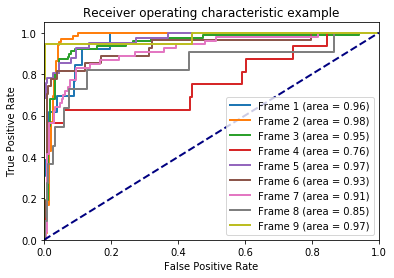

I1018 11:18:08.235924 47382659590592 <ipython-input-13-7f03f770a8ad>:93] ***** Eval results  *****
I1018 11:18:08.236648 47382659590592 <ipython-input-13-7f03f770a8ad>:95]   auc = 0.9207217572548225


{'auc': 0.9207217572548225}
Hamming loss (proportion of wrong labels among all labels):  0.05449936628643853
Exact match:  0.6920152091254753
Number of articles with multiple frames:  59
Accuracy among those:  0.4406779661016949


{'auc_': 0.9207217572548225}

In [17]:
#multilingual cased
main()

W1018 11:55:15.582067 47382659590592 <ipython-input-15-fb4439387059>:110] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1018 11:55:15.684464 47382659590592 file_utils.py:296] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json not found in cache or force_download set to True, downloading to /scratch/90046.1.kulisgpu-pub/tmpcx476wv_
100%|██████████| 313/313 [00:00<00:00, 199637.64B/s]
I1018 11:55:15.787593 47382659590592 file_utils.py:309] copying /scratch/90046.1.kulisgpu-pub/tmpcx476wv_ to cache at /usr4/cs591/akyurek/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
I1018 11:55:15.790102 47382659590592 file_utils.py:313] creating metadata file for /usr4/cs591/akyurek/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9

Iteration:  19%|█▉        | 49/260 [00:13<00:58,  3.59it/s]I1018 11:55:59.908193 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-50/config.json
I1018 11:56:00.578510 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-50/pytorch_model.bin
I1018 11:56:00.589569 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-50

Iteration:  38%|███▊      | 99/260 [00:28<00:44,  3.60it/s]I1018 11:56:14.501163 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-100/config.json
I1018 11:56:15.149720 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-100/pytorch_model.bin
I1018 11:56:15.154423 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-100

Iteration:  57%|█████▋    | 149/260 [00:42<00:30,  3.59it/s]I1018 11:56:29.058337 47382659590592 configuration_utils.py

Iteration:  96%|█████████▌| 249/260 [01:11<00:03,  3.59it/s]I1018 11:56:58.177762 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-250/config.json
I1018 11:56:58.825738 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-250/pytorch_model.bin
I1018 11:56:58.829818 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-250

Iteration:  15%|█▌        | 39/260 [00:10<01:01,  3.60it/s]I1018 11:57:12.619229 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-300/config.json
I1018 11:57:13.295452 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-300/pytorch_model.bin
I1018 11:57:13.302337 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-300

Iteration:  34%|███▍      | 89/260 [00:25<00:47,  3.60it/s]I1018 11:57:27.194512 47382659590592 configuration_utils

Iteration:  92%|█████████▏| 239/260 [01:09<00:05,  3.59it/s]I1018 11:58:10.859856 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-500/config.json
I1018 11:58:11.527786 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-500/pytorch_model.bin
I1018 11:58:11.532588 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-500

Iteration:  11%|█         | 29/260 [00:08<01:03,  3.63it/s]I1018 11:58:25.295917 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-550/config.json
I1018 11:58:26.016377 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-550/pytorch_model.bin
I1018 11:58:26.025218 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-550

Iteration:  30%|███       | 79/260 [00:22<00:50,  3.60it/s]I1018 11:58:39.974505 47382659590592 configuration_utils

Iteration:  88%|████████▊ | 229/260 [01:06<00:08,  3.61it/s]I1018 11:59:23.507930 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-750/config.json
I1018 11:59:24.154758 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-750/pytorch_model.bin
I1018 11:59:24.159899 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-750

Iteration:   7%|▋         | 19/260 [00:05<01:06,  3.60it/s]I1018 11:59:37.855280 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-800/config.json
I1018 11:59:38.525172 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-800/pytorch_model.bin
I1018 11:59:38.529212 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-800

Iteration:  27%|██▋       | 69/260 [00:19<00:52,  3.61it/s]I1018 11:59:52.333242 47382659590592 configuration_utils

Iteration:  65%|██████▌   | 169/260 [00:48<00:25,  3.62it/s]I1018 12:00:21.290056 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-950/config.json
I1018 12:00:21.937401 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-950/pytorch_model.bin
I1018 12:00:21.941340 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-950

Iteration:  84%|████████▍ | 219/260 [01:03<00:11,  3.66it/s]I1018 12:00:35.707540 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1000/config.json
I1018 12:00:36.353930 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1000/pytorch_model.bin
I1018 12:00:36.359308 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1000

Iteration:   3%|▎         | 9/260 [00:02<01:09,  3.63it/s]I1018 12:00:50.047854 47382659590592 configuration_ut

Iteration:  61%|██████    | 159/260 [00:45<00:27,  3.63it/s]I1018 12:01:33.243960 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1200/config.json
I1018 12:01:34.215320 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1200/pytorch_model.bin
I1018 12:01:34.220331 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1200

Iteration:  80%|████████  | 209/260 [01:00<00:13,  3.66it/s]I1018 12:01:47.966098 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1250/config.json
I1018 12:01:48.640849 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1250/pytorch_model.bin
I1018 12:01:48.650068 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1250

Iteration: 100%|█████████▉| 259/260 [01:14<00:00,  3.65it/s]I1018 12:02:02.243976 47382659590592 configurati

Iteration:  38%|███▊      | 99/260 [00:27<00:44,  3.65it/s]I1018 12:02:30.995239 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1400/config.json
I1018 12:02:31.644485 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1400/pytorch_model.bin
I1018 12:02:31.649245 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1400

Iteration:  57%|█████▋    | 149/260 [00:42<00:30,  3.65it/s]I1018 12:02:45.376241 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1450/config.json
I1018 12:02:46.024906 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1450/pytorch_model.bin
I1018 12:02:46.031443 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1450

Iteration:  77%|███████▋  | 199/260 [00:56<00:16,  3.62it/s]I1018 12:02:59.714230 47382659590592 configuratio


Iteration:  96%|█████████▌| 249/260 [01:10<00:03,  3.65it/s]I1018 12:03:14.101107 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1550/config.json
I1018 12:03:14.751707 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1550/pytorch_model.bin
I1018 12:03:14.757633 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1550

Iteration:  15%|█▌        | 39/260 [00:10<00:59,  3.69it/s]I1018 12:03:28.354262 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1600/config.json
I1018 12:03:29.015683 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1600/pytorch_model.bin
I1018 12:03:29.020540 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1600

Iteration:  34%|███▍      | 89/260 [00:25<00:47,  3.62it/s]I1018 12:03:42.710437 47382659590592 configuratio

Iteration:  73%|███████▎  | 189/260 [00:53<00:19,  3.66it/s]I1018 12:04:11.419195 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1750/config.json
I1018 12:04:12.089871 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1750/pytorch_model.bin
I1018 12:04:12.098724 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1750

Iteration:  92%|█████████▏| 239/260 [01:08<00:05,  3.66it/s]I1018 12:04:25.796050 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-1800/config.json
I1018 12:04:26.444733 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-1800/pytorch_model.bin
I1018 12:04:26.450031 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-1800

Iteration:  11%|█         | 29/260 [00:07<01:03,  3.65it/s]I1018 12:04:39.981115 47382659590592 configuratio

Iteration:  69%|██████▉   | 179/260 [00:50<00:22,  3.61it/s]I1018 12:05:23.068522 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2000/config.json
I1018 12:05:23.787252 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2000/pytorch_model.bin
I1018 12:05:23.792716 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2000

Iteration:  88%|████████▊ | 229/260 [01:05<00:08,  3.65it/s]I1018 12:05:37.435406 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2050/config.json
I1018 12:05:38.149388 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2050/pytorch_model.bin
I1018 12:05:38.153172 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2050

Iteration:   7%|▋         | 19/260 [00:05<01:05,  3.68it/s]I1018 12:05:51.635083 47382659590592 configuratio

Iteration:  46%|████▌     | 119/260 [00:33<00:38,  3.65it/s]I1018 12:06:20.419186 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2200/config.json
I1018 12:06:21.137145 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2200/pytorch_model.bin
I1018 12:06:21.152163 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2200

Iteration:  65%|██████▌   | 169/260 [00:48<00:24,  3.66it/s]I1018 12:06:34.856223 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2250/config.json
I1018 12:06:35.576405 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2250/pytorch_model.bin
I1018 12:06:35.580941 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2250

Iteration:  84%|████████▍ | 219/260 [01:02<00:11,  3.69it/s]I1018 12:06:49.164784 47382659590592 configurati


Iteration:   3%|▎         | 9/260 [00:02<01:08,  3.66it/s]I1018 12:07:03.426015 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2350/config.json
I1018 12:07:04.163782 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2350/pytorch_model.bin
I1018 12:07:04.167915 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2350

Iteration:  23%|██▎       | 59/260 [00:16<00:54,  3.68it/s]I1018 12:07:17.831672 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2400/config.json
I1018 12:07:18.546546 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2400/pytorch_model.bin
I1018 12:07:18.551056 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2400

Iteration:  42%|████▏     | 109/260 [00:31<00:41,  3.65it/s]I1018 12:07:32.156336 47382659590592 configuration

Iteration:  80%|████████  | 209/260 [00:59<00:13,  3.67it/s]I1018 12:08:00.941949 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2550/config.json
I1018 12:08:01.680046 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2550/pytorch_model.bin
I1018 12:08:01.684231 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2550

Iteration: 100%|█████████▉| 259/260 [01:14<00:00,  3.65it/s]I1018 12:08:15.155362 47382659590592 configuration_utils.py:70] Configuration saved in bert_output/checkpoint-2600/config.json
I1018 12:08:15.872464 47382659590592 modeling_utils.py:205] Model weights saved in bert_output/checkpoint-2600/pytorch_model.bin
I1018 12:08:15.876647 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output/checkpoint-2600

Epoch: 100%|██████████| 10/10 [12:29<00:00, 74.83s/it]8it/s]
I1018 12:08:15.899275 47382659590592 <ipython-i

I1018 12:08:19.904135 47382659590592 tokenization_utils.py:370] loading file bert_output/added_tokens.json
I1018 12:08:19.904899 47382659590592 tokenization_utils.py:370] loading file bert_output/special_tokens_map.json
I1018 12:08:19.905666 47382659590592 tokenization_utils.py:370] loading file bert_output/tokenizer_config.json
I1018 12:08:19.962492 47382659590592 <ipython-input-15-fb4439387059>:181] Evaluate the following checkpoints: ['bert_output']
I1018 12:08:19.963701 47382659590592 configuration_utils.py:148] loading configuration file bert_output/config.json
I1018 12:08:19.964907 47382659590592 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "outpu

preds shape:  (263, 9)
out label ids:  (263, 9)
[[0.01694706 0.00361117 0.9817386  0.0734073  0.14192045 0.01047219
  0.00509638 0.04110993 0.00557649]
 [0.01878825 0.01362717 0.0185039  0.02329214 0.03015293 0.97606206
  0.03332512 0.02985614 0.01623917]
 [0.02355079 0.0039293  0.02162997 0.07842961 0.05156181 0.01292698
  0.01265248 0.5461138  0.00982897]
 [0.00883563 0.00812909 0.01062186 0.5365913  0.5579327  0.02258761
  0.00335116 0.12130956 0.00718373]
 [0.01820121 0.0143407  0.01857713 0.01652319 0.03110326 0.9670236
  0.0256306  0.01846602 0.0138386 ]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
length:  9


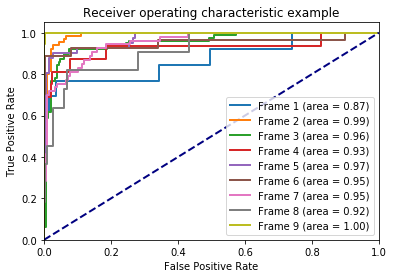

I1018 12:08:27.704968 47382659590592 <ipython-input-13-7f03f770a8ad>:93] ***** Eval results  *****
I1018 12:08:27.705716 47382659590592 <ipython-input-13-7f03f770a8ad>:95]   auc = 0.9493028249140871


{'auc': 0.9493028249140871}
Hamming loss (proportion of wrong labels among all labels):  0.03802281368821293
Exact match:  0.7452471482889734
Number of articles with multiple frames:  59
Accuracy among those:  0.5084745762711864


{'auc_': 0.9493028249140871}

In [19]:
#english cased
main()

W1018 12:30:13.298868 47382659590592 <ipython-input-15-fb4439387059>:110] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1018 12:30:13.431625 47382659590592 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1018 12:30:13.443064 47382659590592 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "outp


Iteration:  38%|███▊      | 99/260 [00:32<00:50,  3.16it/s]I1018 12:30:53.061041 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-100/config.json
I1018 12:30:54.351464 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-100/pytorch_model.bin
I1018 12:30:54.355696 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-100

Iteration:  57%|█████▋    | 149/260 [00:49<00:35,  3.17it/s]I1018 12:31:10.114029 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-150/config.json
I1018 12:31:11.397242 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-150/pytorch_model.bin
I1018 12:31:11.401034 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/chec

Iteration:  15%|█▌        | 39/260 [00:12<01:09,  3.16it/s]I1018 12:32:01.317788 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-300/config.json
I1018 12:32:02.606357 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-300/pytorch_model.bin
I1018 12:32:02.609240 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-300

Iteration:  34%|███▍      | 89/260 [00:29<00:54,  3.15it/s]I1018 12:32:18.438480 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-350/config.json
I1018 12:32:19.727221 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-350/pytorch_model.bin
I1018 12:32:19.730163 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkp


Iteration:  11%|█         | 29/260 [00:09<01:12,  3.17it/s]I1018 12:33:26.607534 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-550/config.json
I1018 12:33:27.897883 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-550/pytorch_model.bin
I1018 12:33:27.901113 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-550

Iteration:  30%|███       | 79/260 [00:26<00:56,  3.21it/s]I1018 12:33:43.641373 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-600/config.json
I1018 12:33:44.931396 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-600/pytorch_model.bin
I1018 12:33:44.934467 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/check

Iteration:  88%|████████▊ | 229/260 [01:17<00:09,  3.17it/s]I1018 12:34:34.831119 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-750/config.json
I1018 12:34:36.123646 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-750/pytorch_model.bin
I1018 12:34:36.127430 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-750

Iteration:   7%|▋         | 19/260 [00:05<01:16,  3.17it/s]I1018 12:34:51.713102 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-800/config.json
I1018 12:34:53.004460 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-800/pytorch_model.bin
I1018 12:34:53.008383 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/check


Iteration:  84%|████████▍ | 219/260 [01:13<00:12,  3.19it/s]I1018 12:35:59.584253 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1000/config.json
I1018 12:36:00.856244 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1000/pytorch_model.bin
I1018 12:36:00.859117 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-1000

Iteration:   3%|▎         | 9/260 [00:02<01:17,  3.22it/s]I1018 12:36:16.399020 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1050/config.json
I1018 12:36:17.667402 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1050/pytorch_model.bin
I1018 12:36:17.672463 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/

Iteration:  61%|██████    | 159/260 [00:53<00:31,  3.20it/s]I1018 12:37:07.100105 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1200/config.json
I1018 12:37:08.370783 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1200/pytorch_model.bin
I1018 12:37:08.373717 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-1200

Iteration:  80%|████████  | 209/260 [01:10<00:15,  3.23it/s]I1018 12:37:23.968085 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1250/config.json
I1018 12:37:25.236077 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1250/pytorch_model.bin
I1018 12:37:25.239793 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased


Iteration:  57%|█████▋    | 149/260 [00:48<00:34,  3.24it/s]I1018 12:38:31.279193 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1450/config.json
I1018 12:38:32.551644 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1450/pytorch_model.bin
I1018 12:38:32.555643 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-1450

Iteration:  77%|███████▋  | 199/260 [01:05<00:19,  3.18it/s]I1018 12:38:48.151866 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1500/config.json
I1018 12:38:49.419776 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1500/pytorch_model.bin
I1018 12:38:49.422800 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncase

Iteration:  96%|█████████▌| 249/260 [01:22<00:03,  3.25it/s]I1018 12:39:05.001721 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1550/config.json
I1018 12:39:06.270421 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1550/pytorch_model.bin
I1018 12:39:06.273645 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-1550

Iteration:  15%|█▌        | 39/260 [00:12<01:08,  3.23it/s]I1018 12:39:21.634057 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1600/config.json
I1018 12:39:22.904483 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1600/pytorch_model.bin
I1018 12:39:22.907681 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/

Iteration:  73%|███████▎  | 189/260 [01:02<00:22,  3.23it/s]I1018 12:40:12.013824 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1750/config.json
I1018 12:40:13.273501 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1750/pytorch_model.bin
I1018 12:40:13.276376 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-1750

Iteration:  92%|█████████▏| 239/260 [01:19<00:06,  3.21it/s]I1018 12:40:28.833695 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1800/config.json
I1018 12:40:30.089453 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1800/pytorch_model.bin
I1018 12:40:30.092688 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased


Iteration:  30%|███       | 79/260 [00:25<00:56,  3.23it/s]I1018 12:41:02.246856 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-1900/config.json
I1018 12:41:03.493013 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-1900/pytorch_model.bin
I1018 12:41:03.498073 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-1900

Iteration:  84%|████████▍ | 219/260 [01:12<00:12,  3.23it/s]I1018 12:43:16.040043 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-2300/config.json
I1018 12:43:17.286528 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-2300/pytorch_model.bin
I1018 12:43:17.289577 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased

Iteration:  42%|████▏     | 109/260 [00:36<00:46,  3.23it/s]I1018 12:44:06.129973 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-2450/config.json
I1018 12:44:07.367489 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-2450/pytorch_model.bin
I1018 12:44:07.370390 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased/checkpoint-2450

Iteration:  61%|██████    | 159/260 [00:52<00:31,  3.23it/s]I1018 12:44:22.853758 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_multilingual_uncased/checkpoint-2500/config.json
I1018 12:44:24.091199 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_multilingual_uncased/checkpoint-2500/pytorch_model.bin
I1018 12:44:24.094791 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_multilingual_uncased

I1018 12:45:04.401160 47382659590592 modeling_utils.py:334] loading weights file bert_output_multilingual_uncased/pytorch_model.bin
I1018 12:45:09.326989 47382659590592 <ipython-input-14-5385282ede45>:15] Loading features from cached file dataset/0/cached_dev_bert-base-multilingual-uncased_128_frame
I1018 12:45:09.358324 47382659590592 <ipython-input-13-7f03f770a8ad>:19] ***** Running evaluation  *****
I1018 12:45:09.359139 47382659590592 <ipython-input-13-7f03f770a8ad>:20]   Num examples = 263
I1018 12:45:09.360001 47382659590592 <ipython-input-13-7f03f770a8ad>:21]   Batch size = 8
Evaluating: 100%|██████████| 33/33 [00:04<00:00,  7.84it/s]


preds shape:  (263, 9)
out label ids:  (263, 9)
[[0.00641785 0.00774827 0.11744928 0.07964159 0.85637    0.00788516
  0.00494396 0.01533365 0.0042123 ]
 [0.01451894 0.0134449  0.00871762 0.02746829 0.02761191 0.9738574
  0.03275537 0.03378139 0.01475895]
 [0.02999844 0.00911674 0.01203873 0.8710075  0.03402162 0.01464205
  0.04743391 0.08513666 0.01431633]
 [0.02069904 0.02251911 0.01240212 0.9034599  0.04326384 0.02238856
  0.01424799 0.03493809 0.01531762]
 [0.01016908 0.00928711 0.02098522 0.01296748 0.07638957 0.9483169
  0.0223646  0.01315499 0.01251543]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
length:  9


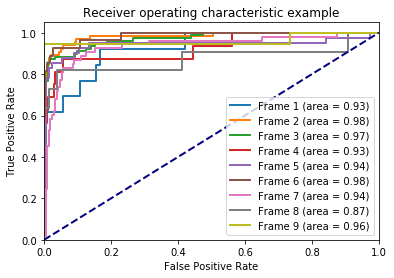

I1018 12:45:14.055046 47382659590592 <ipython-input-13-7f03f770a8ad>:93] ***** Eval results  *****
I1018 12:45:14.055802 47382659590592 <ipython-input-13-7f03f770a8ad>:95]   auc = 0.9453030232769214


{'auc': 0.9453030232769214}
Hamming loss (proportion of wrong labels among all labels):  0.04224757076468103
Exact match:  0.7338403041825095
Number of articles with multiple frames:  59
Accuracy among those:  0.4915254237288136


{'auc_': 0.9453030232769214}

In [21]:
#multilingual uncased
main()

In [ ]:
#english uncased
main()

W1018 13:30:35.065402 47382659590592 <ipython-input-15-fb4439387059>:110] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1018 13:30:35.174237 47382659590592 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1018 13:30:35.176744 47382659590592 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_attentions": false,
  "output_hidden_s

Iteration:  77%|███████▋  | 199/260 [00:57<00:16,  3.59it/s]I1018 13:31:38.153697 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-200/config.json
I1018 13:31:38.829152 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-200/pytorch_model.bin
I1018 13:31:38.832226 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-200

Iteration:  96%|█████████▌| 249/260 [01:12<00:03,  3.60it/s]I1018 13:31:52.782045 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-250/config.json
I1018 13:31:53.456494 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-250/pytorch_model.bin
I1018 13:31:53.460210 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-250

Iteration:   9%|▉         | 24/260 [00:06<01:05,  3.60it/s]


Iteration:  15%|█▌        | 39/260 [00:10<01:01,  3.58it/s]I1018 13:32:07.309577 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-300/config.json
I1018 13:32:08.002875 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-300/pytorch_model.bin
I1018 13:32:08.006287 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-300

Iteration:  34%|███▍      | 89/260 [00:25<00:47,  3.59it/s]I1018 13:32:21.913473 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-350/config.json
I1018 13:32:22.584346 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-350/pytorch_model.bin
I1018 13:32:22.587497 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-350

Iteration:  53%|█████▎    | 139/260 [00:40<00:33,  3.60it/s]I1018 13

I1018 13:32:37.193723 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-400/pytorch_model.bin
I1018 13:32:37.196815 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-400

Iteration:  73%|███████▎  | 189/260 [00:54<00:19,  3.58it/s]I1018 13:32:51.124323 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-450/config.json
I1018 13:32:51.813468 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-450/pytorch_model.bin
I1018 13:32:51.816955 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-450

Iteration:  92%|█████████▏| 239/260 [01:09<00:05,  3.60it/s]I1018 13:33:05.725418 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-500/config.json
I1018 13:33:06.482009 47382659590592 modeling_utils.py:205] Model 

Iteration:  50%|████▉     | 129/260 [00:37<00:36,  3.59it/s]I1018 13:33:49.680025 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-650/config.json
I1018 13:33:50.333403 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-650/pytorch_model.bin
I1018 13:33:50.337050 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-650

Iteration:  69%|██████▉   | 179/260 [00:51<00:22,  3.63it/s]I1018 13:34:04.210410 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-700/config.json
I1018 13:34:04.864017 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-700/pytorch_model.bin
I1018 13:34:04.900070 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-700

Iteration:  88%|████████▊ | 229/260 [01:06<00:08,  3.59it/s]I1018 

Iteration:  46%|████▌     | 119/260 [00:34<00:39,  3.60it/s]I1018 13:35:02.752919 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-900/config.json
I1018 13:35:03.417767 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-900/pytorch_model.bin
I1018 13:35:03.420488 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-900

Iteration:  65%|██████▌   | 169/260 [00:49<00:25,  3.63it/s]I1018 13:35:17.428049 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-950/config.json
I1018 13:35:18.389193 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-950/pytorch_model.bin
I1018 13:35:18.392459 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-950

Iteration:  84%|████████▍ | 219/260 [01:04<00:11,  3.62it/s]I1018 

Iteration:  23%|██▎       | 59/260 [00:17<00:55,  3.65it/s]I1018 13:36:01.500783 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1100/config.json
I1018 13:36:03.290987 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1100/pytorch_model.bin
I1018 13:36:03.294382 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1100

Iteration:  42%|████▏     | 109/260 [00:32<00:41,  3.64it/s]I1018 13:36:17.040568 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1150/config.json
I1018 13:36:18.993387 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1150/pytorch_model.bin
I1018 13:36:19.348749 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1150

Iteration:  61%|██████    | 159/260 [00:48<00:27,  3.63it/s]I

Iteration:  19%|█▉        | 49/260 [00:13<00:57,  3.66it/s]I1018 13:37:16.999501 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1350/config.json
I1018 13:37:17.697288 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1350/pytorch_model.bin
I1018 13:37:17.700470 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1350

Iteration:  38%|███▊      | 99/260 [00:27<00:44,  3.64it/s]I1018 13:37:31.406409 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1400/config.json
I1018 13:37:32.127989 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1400/pytorch_model.bin
I1018 13:37:32.217090 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1400

Iteration:  57%|█████▋    | 149/260 [00:42<00:30,  3.66it/s]I1

Iteration:  96%|█████████▌| 249/260 [01:12<00:03,  3.64it/s]I1018 13:38:15.738078 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1550/config.json
I1018 13:38:16.420038 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1550/pytorch_model.bin
I1018 13:38:16.423201 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1550

Iteration:  15%|█▌        | 39/260 [00:10<01:00,  3.66it/s]I1018 13:38:31.975862 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1600/config.json
I1018 13:38:38.511368 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1600/pytorch_model.bin
I1018 13:38:38.514431 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1600

Iteration:  34%|███▍      | 89/260 [00:32<00:46,  3.67it/s]I1

I1018 13:38:52.839066 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1650/pytorch_model.bin
I1018 13:38:52.842558 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1650

Iteration:  53%|█████▎    | 139/260 [00:47<00:33,  3.65it/s]I1018 13:39:06.556415 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1700/config.json
I1018 13:39:07.234431 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1700/pytorch_model.bin
I1018 13:39:07.237698 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1700

Iteration:  73%|███████▎  | 189/260 [01:01<00:19,  3.62it/s]I1018 13:39:20.981810 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1750/config.json
I1018 13:39:21.643485 47382659590592 modeling_utils.py:205] 

Iteration:  30%|███       | 79/260 [00:22<00:50,  3.62it/s]I1018 13:40:04.011443 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1900/config.json
I1018 13:40:04.677295 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1900/pytorch_model.bin
I1018 13:40:04.680196 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1900

Iteration:  50%|████▉     | 129/260 [00:36<00:36,  3.63it/s]I1018 13:40:18.370541 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-1950/config.json
I1018 13:40:19.053827 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-1950/pytorch_model.bin
I1018 13:40:19.058024 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-1950

Iteration:  69%|██████▉   | 179/260 [00:51<00:22,  3.65it/s]I


Iteration:  27%|██▋       | 69/260 [00:19<00:52,  3.67it/s]I1018 13:41:15.762850 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-2150/config.json
I1018 13:41:16.430375 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-2150/pytorch_model.bin
I1018 13:41:16.433336 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-2150

Iteration:  46%|████▌     | 119/260 [00:33<00:38,  3.68it/s]I1018 13:41:30.081070 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-2200/config.json
I1018 13:41:30.729682 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-2200/pytorch_model.bin
I1018 13:41:30.732553 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-2200

Iteration:  65%|██████▌   | 169/260 [00:48<00:24,  3.67it/s]

Iteration:   3%|▎         | 9/260 [00:02<01:08,  3.68it/s]I1018 13:42:13.076464 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-2350/config.json
I1018 13:42:13.727029 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-2350/pytorch_model.bin
I1018 13:42:13.732233 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-2350

Iteration:  23%|██▎       | 59/260 [00:16<00:55,  3.64it/s]I1018 13:42:27.393678 47382659590592 configuration_utils.py:70] Configuration saved in bert_output_uncased/checkpoint-2400/config.json
I1018 13:42:28.060781 47382659590592 modeling_utils.py:205] Model weights saved in bert_output_uncased/checkpoint-2400/pytorch_model.bin
I1018 13:42:28.063749 47382659590592 <ipython-input-11-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_uncased/checkpoint-2400

Iteration:  42%|████▏     | 109/260 [00:31<00:41,  3.65it/s]I10

W1014 18:42:22.917361 47346561829312 <ipython-input-18-fb4439387059>:110] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1014 18:42:23.098289 47346561829312 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/33b56ce0f312e47e4d77a57791a4fc6233ae4a560dd2bdd186107058294e58ab.3d3939ed0a2ebc86dd3c4703e5a591dcfb3341e9bbf87d411dea195948a37c74
I1014 18:42:23.099963 47346561829312 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "outp

Iteration:  15%|█▍        | 38/260 [00:02<00:16, 13.51it/s]I1014 18:43:01.915029 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-300/config.json
I1014 18:43:03.227858 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-300/pytorch_model.bin
I1014 18:43:03.232137 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-300

Iteration:  34%|███▍      | 88/260 [00:07<00:12, 13.53it/s]I1014 18:43:06.918548 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-350/config.json
I1014 18:43:08.224039 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-350/pytorch_model.bin
I1014 18:43:08.228836 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-350

It

Iteration:  68%|██████▊   | 178/260 [00:16<00:05, 13.85it/s]I1014 18:43:41.608886 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-700/config.json
I1014 18:43:42.900787 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-700/pytorch_model.bin
I1014 18:43:42.905409 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-700

Iteration:  88%|████████▊ | 228/260 [00:21<00:02, 13.96it/s]I1014 18:43:46.528897 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-750/config.json
I1014 18:43:47.818396 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-750/pytorch_model.bin
I1014 18:43:47.823662 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-750



Iteration:  22%|██▏       | 58/260 [00:05<00:14, 13.89it/s]I1014 18:44:20.978689 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-1100/config.json
I1014 18:44:22.653881 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-1100/pytorch_model.bin
I1014 18:44:22.658090 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-1100

Iteration:  42%|████▏     | 108/260 [00:10<00:10, 13.90it/s]I1014 18:44:26.246084 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-1150/config.json
I1014 18:44:27.946319 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-1150/pytorch_model.bin
I1014 18:44:27.951018 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-1

Iteration:  76%|███████▌  | 198/260 [00:19<00:04, 13.89it/s]I1014 18:45:02.884966 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-1500/config.json
I1014 18:45:04.456979 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-1500/pytorch_model.bin
I1014 18:45:04.462090 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-1500

Iteration:  95%|█████████▌| 248/260 [00:24<00:00, 13.93it/s]I1014 18:45:08.052228 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-1550/config.json
I1014 18:45:09.622029 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-1550/pytorch_model.bin
I1014 18:45:09.626458 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-

Iteration:  30%|███       | 78/260 [00:06<00:12, 14.17it/s]I1014 18:45:43.532794 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-1900/config.json
I1014 18:45:44.918318 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-1900/pytorch_model.bin
I1014 18:45:44.923607 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-1900

Iteration:  49%|████▉     | 128/260 [00:11<00:09, 14.18it/s]I1014 18:45:48.457739 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-1950/config.json
I1014 18:45:49.834500 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-1950/pytorch_model.bin
I1014 18:45:49.840126 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-1

Iteration:  84%|████████▍ | 218/260 [00:20<00:02, 14.13it/s]I1014 18:46:22.971063 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-2300/config.json
I1014 18:46:24.353339 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-2300/pytorch_model.bin
I1014 18:46:24.357234 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-2300

Iteration:   3%|▎         | 8/260 [00:00<00:17, 14.11it/s]I1014 18:46:27.910062 47346561829312 configuration_utils.py:70] Configuration saved in bert_output_mutlilingual_cased/checkpoint-2350/config.json
I1014 18:46:29.293092 47346561829312 modeling_utils.py:205] Model weights saved in bert_output_mutlilingual_cased/checkpoint-2350/pytorch_model.bin
I1014 18:46:29.297619 47346561829312 <ipython-input-13-ce0a3a7e9c33>:107] Saving model checkpoint to bert_output_mutlilingual_cased/checkpoint-23

I1014 18:46:59.939364 47346561829312 tokenization_utils.py:370] loading file bert_output_mutlilingual_cased/special_tokens_map.json
I1014 18:46:59.940014 47346561829312 tokenization_utils.py:370] loading file bert_output_mutlilingual_cased/tokenizer_config.json
I1014 18:47:00.181553 47346561829312 <ipython-input-18-fb4439387059>:181] Evaluate the following checkpoints: ['bert_output_mutlilingual_cased']
I1014 18:47:00.183044 47346561829312 configuration_utils.py:148] loading configuration file bert_output_mutlilingual_cased/config.json
I1014 18:47:00.184162 47346561829312 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_a

preds shape:  (263, 9)
out label ids:  (263, 9)
[[0.01423015 0.02182806 0.06950232 0.7868451  0.14007674 0.01471578
  0.00524659 0.02217446 0.00773888]
 [0.01215458 0.01103574 0.00603635 0.05186746 0.048393   0.97418106
  0.04332058 0.04945757 0.01418138]
 [0.01507436 0.0082345  0.01210421 0.78430957 0.08987287 0.01107814
  0.0261486  0.03306131 0.01354449]
 [0.02113908 0.0259786  0.01688389 0.92976    0.04313533 0.02356634
  0.01978928 0.04160449 0.0179706 ]
 [0.00838097 0.00616693 0.02063526 0.00827147 0.0604271  0.9323913
  0.06060061 0.01141125 0.01471036]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
length:  9


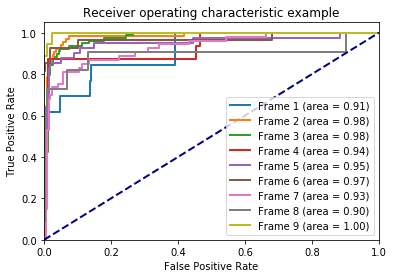

I1014 18:47:05.810430 47346561829312 <ipython-input-15-b336438098bc>:82] ***** Eval results  *****
I1014 18:47:05.811176 47346561829312 <ipython-input-15-b336438098bc>:84]   auc = 0.9512310977305601


{'auc': 0.9512310977305601}


{'auc_': 0.9512310977305601}

In [19]:
#multi lingual uncased
main()

W1014 14:05:49.849627 47925521336768 <ipython-input-15-fb4439387059>:110] Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
I1014 14:05:49.949977 47925521336768 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /usr4/cs591/akyurek/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
I1014 14:05:49.951650 47925521336768 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "frame",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 9,
  "output_attentions": false,
  "output_hidden_sta

preds shape:  (263, 9)
out label ids:  (263, 9)
[[0.00920546 0.0050703  0.8210223  0.49708992 0.08384976 0.01146775
  0.00370745 0.043563   0.00552611]
 [0.01327827 0.01413584 0.02024557 0.02304885 0.03063032 0.9699369
  0.02601531 0.03138949 0.01738443]
 [0.03360216 0.01113563 0.01220965 0.0251116  0.1388215  0.01353287
  0.00809702 0.49573562 0.01237645]
 [0.00908147 0.0164304  0.01402232 0.60032433 0.60190356 0.02522935
  0.00398023 0.03535081 0.00764521]
 [0.019145   0.01561153 0.02028489 0.01663143 0.03528612 0.9601685
  0.02668507 0.01709183 0.01178133]]
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]]
length:  9


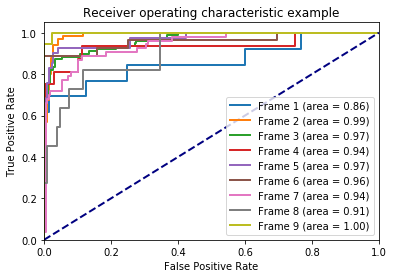

I1014 14:05:57.137552 47925521336768 <ipython-input-24-b336438098bc>:82] ***** Eval results  *****
I1014 14:05:57.138645 47925521336768 <ipython-input-24-b336438098bc>:84]   auc = 0.948673714653332


{'auc': 0.948673714653332}


{'auc_': 0.948673714653332}

In [31]:
#--do_lower_case=True
main()

In [64]:
def count_frames(file, name):
    df = pd.read_csv(file, sep='\t', header=None)
    df.columns = ["guid", "text_a", "text_b"] + [str(x+1) for x in range(9)]
    return(df.iloc[:,3:].sum(axis=0))

In [65]:
distributions_test = dict()
distributions_train = dict()
for i in range(5):
    distributions_test[i] = count_frames("dataset/"+str(i)+"/dev.tsv", "test")
    distributions_train[i] = count_frames("dataset/"+str(i)+"/train.tsv", "train")

In [86]:
test_dist_df = pd.DataFrame(distributions_test)
test_dist_df.columns = ["test" + str(t) for t in test_dist_df.columns]
test_dist_df

,test0,test1,test2,test3,test4
1,13.0,11.0,16.0,14.0,12.0
2,65.0,62.0,61.0,67.0,67.0
3,78.0,88.0,94.0,81.0,86.0
4,16.0,18.0,16.0,15.0,15.0
5,41.0,36.0,33.0,38.0,34.0
6,27.0,28.0,29.0,26.0,24.0
7,53.0,54.0,53.0,52.0,51.0
8,11.0,9.0,11.0,10.0,9.0
9,18.0,20.0,17.0,21.0,19.0


In [87]:
train_dist_df = pd.DataFrame(distributions_train)
train_dist_df.columns = ["train" + str(t) for t in train_dist_df.columns]
train_dist_df

,train0,train1,train2,train3,train4
1,53.0,55.0,50.0,52.0,54.0
2,257.0,260.0,261.0,255.0,255.0
3,349.0,339.0,333.0,346.0,341.0
4,64.0,62.0,64.0,65.0,65.0
5,141.0,146.0,149.0,144.0,148.0
6,107.0,106.0,105.0,108.0,110.0
7,210.0,209.0,210.0,211.0,212.0
8,39.0,41.0,39.0,40.0,41.0
9,77.0,75.0,78.0,74.0,76.0


In [91]:
train_dist_df

,train0,train1,train2,train3,train4
1,53.0,55.0,50.0,52.0,54.0
2,257.0,260.0,261.0,255.0,255.0
3,349.0,339.0,333.0,346.0,341.0
4,64.0,62.0,64.0,65.0,65.0
5,141.0,146.0,149.0,144.0,148.0
6,107.0,106.0,105.0,108.0,110.0
7,210.0,209.0,210.0,211.0,212.0
8,39.0,41.0,39.0,40.0,41.0
9,77.0,75.0,78.0,74.0,76.0


In [92]:
dists = pd.concat([test_dist_df, train_dist_df], axis=1)
col_order = 
print(dists)

   test0  test1  test2  test3  test4  train0  train1  train2  train3  train4
1   13.0   11.0   16.0   14.0   12.0    53.0    55.0    50.0    52.0    54.0
2   65.0   62.0   61.0   67.0   67.0   257.0   260.0   261.0   255.0   255.0
3   78.0   88.0   94.0   81.0   86.0   349.0   339.0   333.0   346.0   341.0
4   16.0   18.0   16.0   15.0   15.0    64.0    62.0    64.0    65.0    65.0
5   41.0   36.0   33.0   38.0   34.0   141.0   146.0   149.0   144.0   148.0
6   27.0   28.0   29.0   26.0   24.0   107.0   106.0   105.0   108.0   110.0
7   53.0   54.0   53.0   52.0   51.0   210.0   209.0   210.0   211.0   212.0
8   11.0    9.0   11.0   10.0    9.0    39.0    41.0    39.0    40.0    41.0
9   18.0   20.0   17.0   21.0   19.0    77.0    75.0    78.0    74.0    76.0


In [68]:
# 1 Gun/2nd Amendment rights
# 2 Gun control/regulation  
# 3 Politics 
# 4 Mental health 
# 5 School or public space safety 
# 6 Race/ethnicity 
# 7 Public opinion
# 8 Society/culture
# 9 Economic consequences 
